## Imports

In [1]:
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
# Seperated the functions in a .py file to make the notebook cleaner
from helper_functions import *

# Magic commands to autoreload py file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

Normally I would use the os module here to make the folder structure platform independent with os.path.join()
However, only numpy, scipy and matplotlib are allowed here.

In [2]:
data_folder = "raw_data"

first_ecg = np.load(data_folder + "/first_ecg.npy")
first_ppg = np.load(data_folder + "/first_ppg.npy")

second_ecg = np.load(data_folder + "/second_ecg.npy")
second_ppg = np.load(data_folder + "/second_ppg.npy")

third_ecg = np.load(data_folder + "/third_ecg.npy")
third_ppg = np.load(data_folder + "/third_ppg.npy")

## 1. Sampling frequencies

I think there must be a simpler way, but i came up with the idea to calulate the sampling frequencies, using the timesteps between pulses and the information that it was recorded from health subjects at rest. I just assumed a bpm of 70.

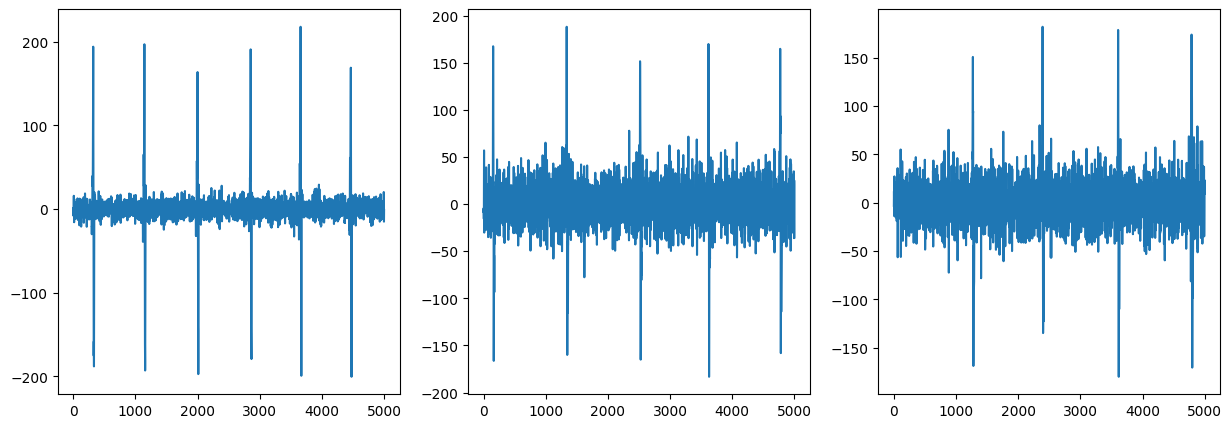

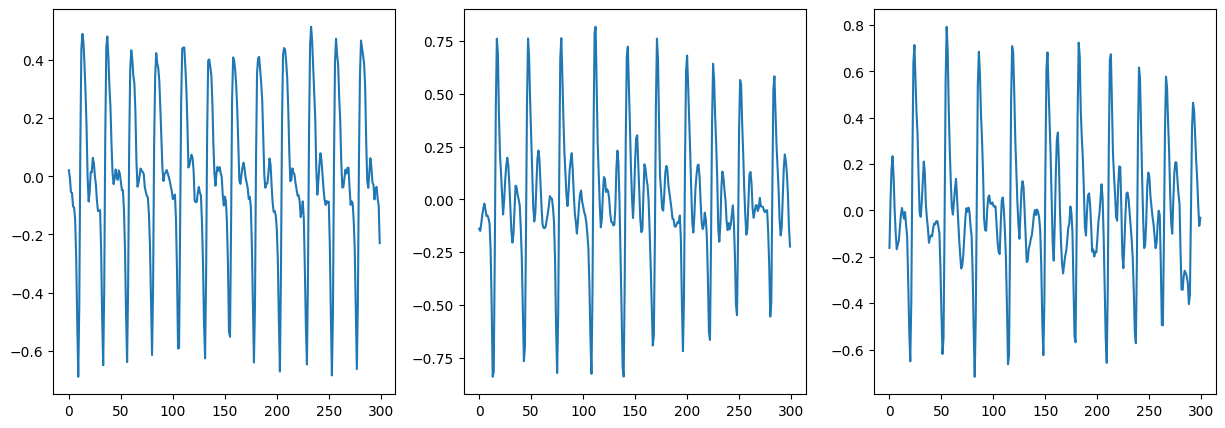

In [3]:
# Simple detrending to find approx pulse locations
first_ecg_ma_detrended = simple_ma_detrending(first_ecg)
first_ppg_ma_detrended = simple_ma_detrending(first_ppg)

second_ecg_ma_detrended = simple_ma_detrending(second_ecg)
second_ppg_ma_detrended = simple_ma_detrending(second_ppg)

third_ecg_ma_detrended = simple_ma_detrending(third_ecg)
third_ppg_ma_detrended = simple_ma_detrending(third_ppg)

# Looking at specific ranges, to find a good threshold for highest-peak detection
plot_three_signals(first_ecg_ma_detrended[40000:45000], second_ecg_ma_detrended[40000:45000], third_ecg_ma_detrended[40000:45000])
plot_three_signals(first_ppg_ma_detrended[500:800], second_ppg_ma_detrended[500:800], third_ppg_ma_detrended[500:800])

In [4]:
ecg_highest_peaks_threshold = 100
ppg_highest_peaks_threshold = 0.35

# Detecting highest peaks and number of steps between them (length of one cycle) to calculate sampling frequencies
first_ecg_freq = find_frequency(first_ecg_ma_detrended, ecg_highest_peaks_threshold)
first_ppg_freq = find_frequency(first_ppg_ma_detrended, ppg_highest_peaks_threshold)

second_ecg_freq = find_frequency(second_ecg_ma_detrended, ecg_highest_peaks_threshold)
second_ppg_freq = find_frequency(second_ppg_ma_detrended, ppg_highest_peaks_threshold)

third_ecg_freq = find_frequency(third_ecg_ma_detrended, ecg_highest_peaks_threshold)
third_ppg_freq = find_frequency(third_ppg_ma_detrended, ppg_highest_peaks_threshold)

ecg_freq = np.mean([first_ecg_freq, second_ecg_freq, third_ecg_freq])
ppg_freq = np.mean([first_ppg_freq, second_ppg_freq, third_ppg_freq])

print("ECG Frequency: ", ecg_freq)
print("PPG Frequency: ", ppg_freq)

ECG Frequency:  1039.5
PPG Frequency:  20.61111111111111


I got the most reasonable results when taking the mean of the three sampling frequencies

## 2. Preprocess signals

I tried different detrending and noise/offset reduction methods. But using the scipy (butter/filtfilt) highpass filter for detrending and lowpass filter for noise reduduction gave the best results.

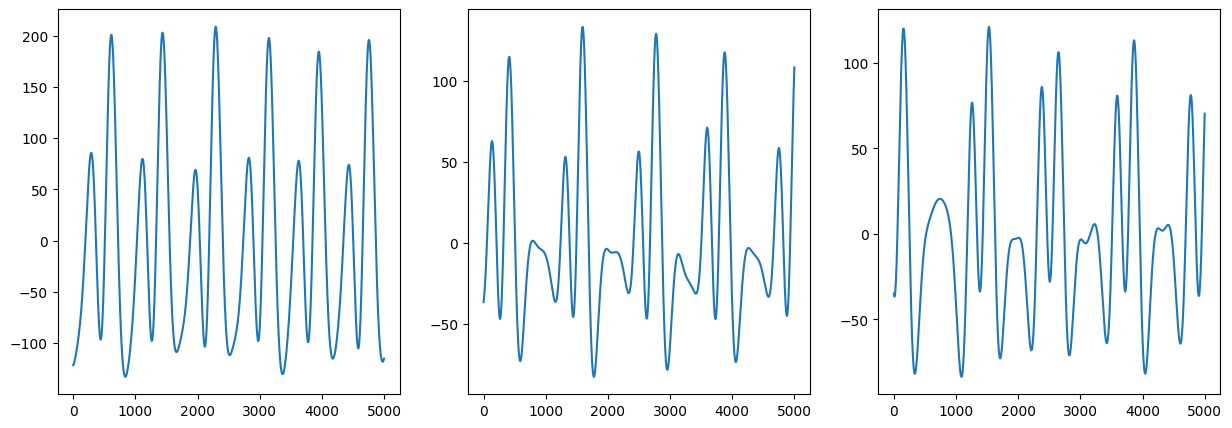

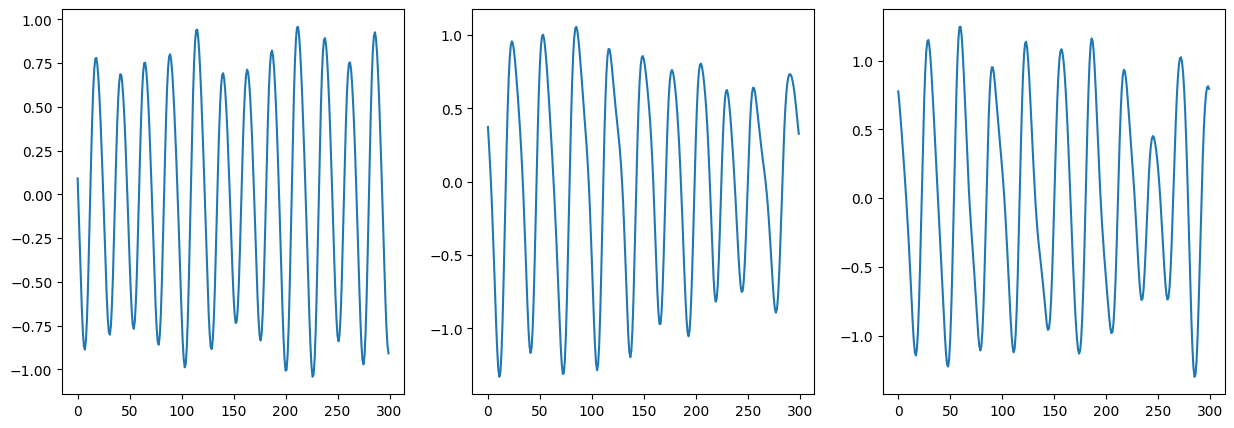

In [5]:
# ecg-finetuning visually
ecg_detrend_cutoff = 1
ecg_smooth_cutoff = 3.6
# ppg-finetuning visually
ppg_detrend_cutoff = 0.4
ppg_smooth_cutoff = 1.5

first_ecg_preprocessed = highpass_process_signal(first_ecg, sampling_rate=ecg_freq, detrend_cutoff=ecg_detrend_cutoff, smooth_cutoff=ecg_smooth_cutoff)
first_ppg_preprocessed = highpass_process_signal(first_ppg, sampling_rate=ppg_freq, detrend_cutoff=ppg_detrend_cutoff, smooth_cutoff=ppg_smooth_cutoff)

second_ecg_preprocessed = highpass_process_signal(second_ecg, sampling_rate=ecg_freq, detrend_cutoff=ecg_detrend_cutoff, smooth_cutoff=ecg_smooth_cutoff)
second_ppg_preprocessed = highpass_process_signal(second_ppg, sampling_rate=ppg_freq, detrend_cutoff=ppg_detrend_cutoff, smooth_cutoff=ppg_smooth_cutoff)

third_ecg_preprocessed = highpass_process_signal(third_ecg, sampling_rate=ecg_freq, detrend_cutoff=ecg_detrend_cutoff, smooth_cutoff=ecg_smooth_cutoff)
third_ppg_preprocessed = highpass_process_signal(third_ppg, sampling_rate=ppg_freq, detrend_cutoff=ppg_detrend_cutoff, smooth_cutoff=ppg_smooth_cutoff)

# Plotting just a part to better see the signal in detail
plot_three_signals(first_ecg_preprocessed[40000:45000], second_ecg_preprocessed[40000:45000], third_ecg_preprocessed[40000:45000])
plot_three_signals(first_ppg_preprocessed[500:800], second_ppg_preprocessed[500:800], third_ppg_preprocessed[500:800])

## 3. Pulse locations

To finally find the pulse locations i simply used the signal.find_peaks method of scipy with a height-threshold, that i found visually

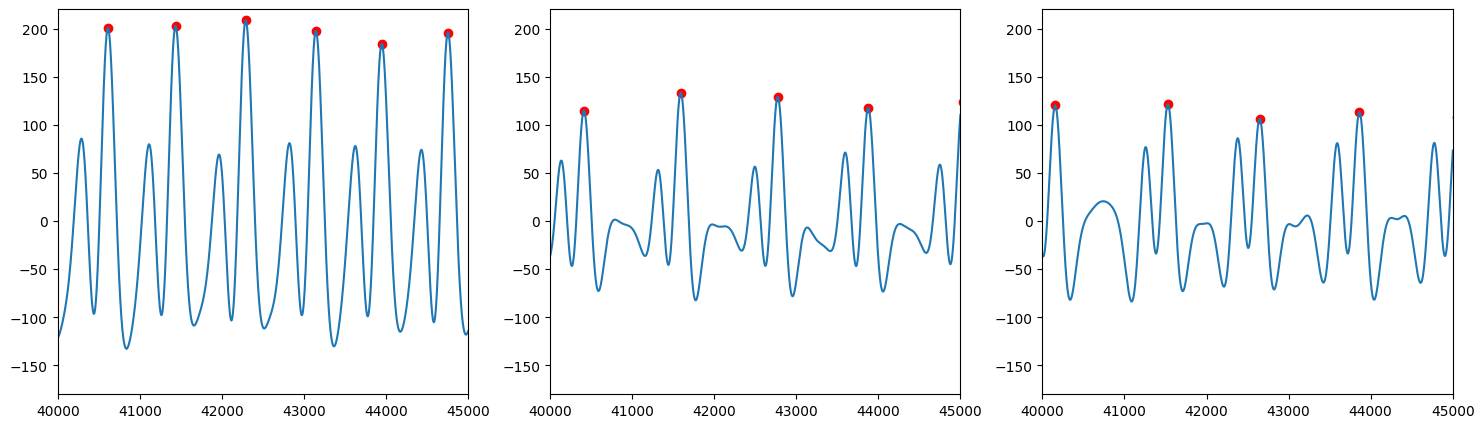

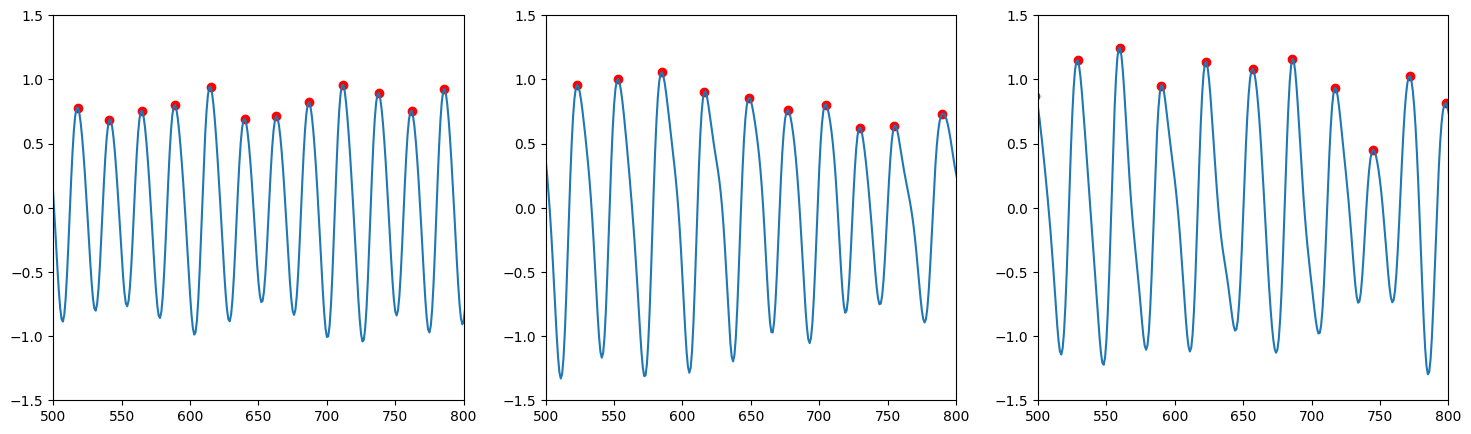

In [6]:
ecg_highest_peaks_threshold = 90
ppg_highest_peaks_threshold = 0.25

first_ecg_pulse_locations = find_pulse_locations(first_ecg_preprocessed, ecg_highest_peaks_threshold)
first_ppg_pulse_locations = find_pulse_locations(first_ppg_preprocessed, ppg_highest_peaks_threshold)

second_ecg_pulse_locations = find_pulse_locations(second_ecg_preprocessed, ecg_highest_peaks_threshold)
second_ppg_pulse_locations = find_pulse_locations(second_ppg_preprocessed, ppg_highest_peaks_threshold)

third_ecg_pulse_locations = find_pulse_locations(third_ecg_preprocessed, ecg_highest_peaks_threshold)
third_ppg_pulse_locations = find_pulse_locations(third_ppg_preprocessed, ppg_highest_peaks_threshold)

# Plotting just a part to better see the signal in detail
plot_signals_with_peaks(first_ecg_preprocessed,
                        second_ecg_preprocessed,
                        third_ecg_preprocessed,
                        first_ecg_pulse_locations,
                        second_ecg_pulse_locations,
                        third_ecg_pulse_locations,
                        xlim=(40000, 45000),
                        ylim=(-180, 220))
plot_signals_with_peaks(first_ppg_preprocessed,
                        second_ppg_preprocessed,
                        third_ppg_preprocessed,
                        first_ppg_pulse_locations,
                        second_ppg_pulse_locations,
                        third_ppg_pulse_locations,
                        xlim=(500, 800),
                        ylim=(-1.5, 1.5))

## 4. Anomalies and Outliers in PPG

To find anomalies i looked at the standardized y values of the peaks and used the following threshold to identify anomalies: Third Quartile + 0.5 * Interquartile Range

In [7]:
first_ppg_anomalies = anomaly_detection(first_ppg_preprocessed[first_ppg_pulse_locations])
second_ppg_anomalies = anomaly_detection(second_ppg_preprocessed[second_ppg_pulse_locations])
third_ppg_anomalies = anomaly_detection(third_ppg_preprocessed[third_ppg_pulse_locations])


print(f"Number of pulses in the first PPG: {len(first_ppg_pulse_locations)}")
print(f"Number of pulses detected as anomaly in the first PPG: {len(first_ppg_anomalies[0])}")
print()
print(f"Number of pulses in the second PPG: {len(second_ppg_pulse_locations)}")
print(f"Number of pulses detected as anomaly in the second PPG: {len(second_ppg_anomalies[0])}")
print()
print(f"Number of pulses in the third PPG: {len(third_ppg_pulse_locations)}")
print(f"Number of pulses detected as anomaly in the third PPG: {len(third_ppg_anomalies[0])}")


Number of pulses in the first PPG: 81
Number of pulses detected as anomaly in the first PPG: 5

Number of pulses in the second PPG: 103
Number of pulses detected as anomaly in the second PPG: 16

Number of pulses in the third PPG: 89
Number of pulses detected as anomaly in the third PPG: 11


## 5. Synchronizing the signals

To synchronize the signals i use the information that the ECG started earlier and stopped later than the PPG.

I iterativly try to cut different amounts of the ECG at both ends, and evaluate to in the end come up with the best number to cut the ECG.

After cutting i always resample the PPG to bring it to the current length of ECG and try even to better fit using cross correlation and lag shifting.

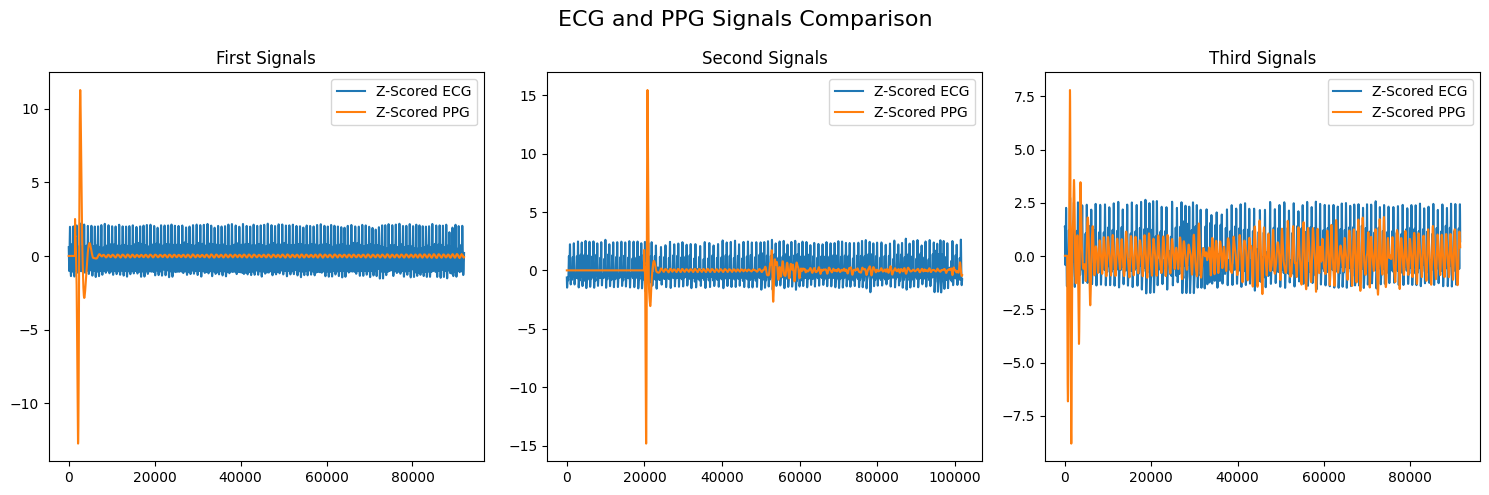

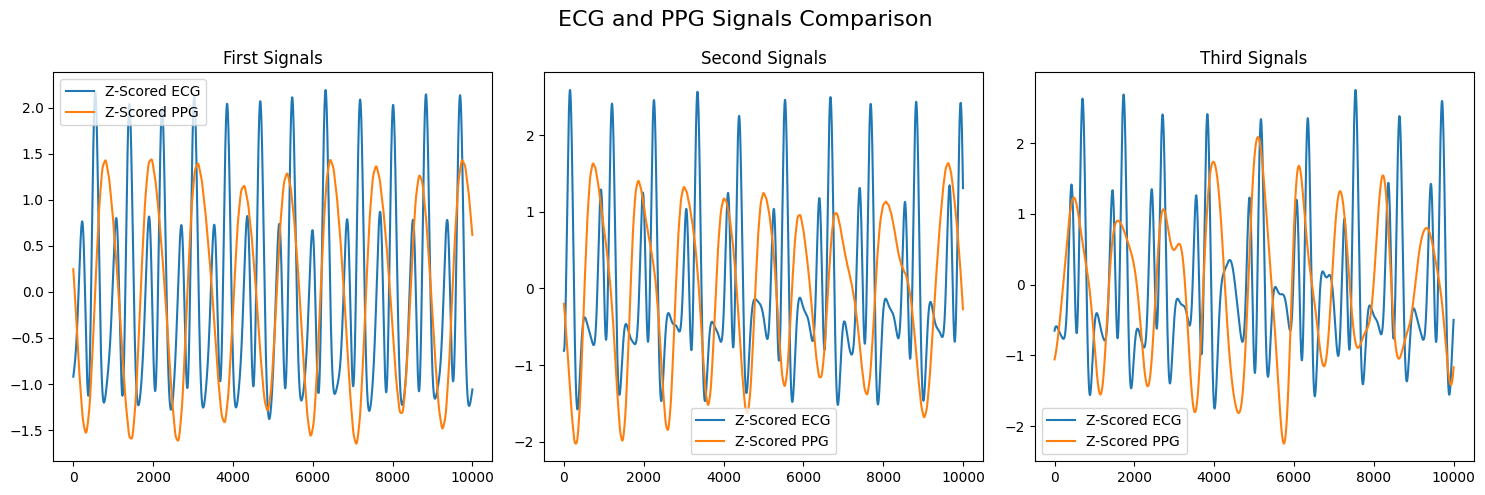

In [10]:
best_ecg_first, best_ppg_first = iterativly_find_best_synch(first_ecg_preprocessed, first_ppg_preprocessed)
best_ecg_second, best_ppg_second = iterativly_find_best_synch(second_ecg_preprocessed, second_ppg_preprocessed)
best_ecg_third, best_ppg_third = iterativly_find_best_synch(third_ecg_preprocessed, third_ppg_preprocessed)

# Plot the whole signal
plot_all_signals(best_ecg_first, best_ppg_first, best_ecg_second, best_ppg_second, best_ecg_third, best_ppg_third)
# Plot just a part to see how it looks in detail
plot_all_signals(best_ecg_first[40000:50000],
                 best_ppg_first[40000:50000],
                 best_ecg_second[40000:50000],
                 best_ppg_second[40000:50000],
                 best_ecg_third[40000:50000],
                 best_ppg_third[40000:50000])


## 6. Best PPG signal

To evaluate the PPG signal, the correlation coefficient is the best metric, because we know that the ECG signal is a much more accurate measuring method. Therefore a strong correlation means a very good PPG.

In [11]:
# compute correlation coeff
corr_first = stats.pearsonr(best_ecg_first, best_ppg_first)[0]
corr_second = stats.pearsonr(best_ecg_second, best_ppg_second)[0]
corr_third = stats.pearsonr(best_ecg_third, best_ppg_third)[0]

# Sort
value_string_pairs = [
    (corr_first, "First PPG"),
    (corr_second, "Second PPG"),
    (corr_third, "Third PPG")
]

# Sort the pairs based on the value (first element of each tuple) in descending order
sorted_pairs = sorted(value_string_pairs, key=lambda x: x[0], reverse=True)

rank_counter = 1
for value, string in sorted_pairs:
    print(f"Rank {rank_counter}: {string} with {value}")
    rank_counter+=1

Rank 1: Third PPG with 0.21763608455066177
Rank 2: Second PPG with 0.1099290882561419
Rank 3: First PPG with 0.03564373759868341
